# Model Evaluation for Binary Classification

In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load the datasets

X_train = pd.read_csv('Binary_Train_data.csv')
X_test = pd.read_csv('Binary_Test_Data.csv')

# Standardize the datasets using a separate scaler for each dataset
scaler_lr = StandardScaler()
scaler_dt = StandardScaler()
scaler_rf = StandardScaler()
scaler_gb = StandardScaler()
scaler_xg = StandardScaler()
scaler_ann = StandardScaler()

# Fit and transform the training data
X_train_lr_b_scaled = scaler_lr.fit_transform(X_train_lr_b)
X_train_dt_b_scaled = scaler_dt.fit_transform(X_train_dt_b)
X_train_rf_b_scaled = scaler_rf.fit_transform(X_train_rf_b)
X_train_gb_b_scaled = scaler_gb.fit_transform(X_train_gb_b)
X_train_xg_b_scaled = scaler_xg.fit_transform(X_train_xg_b)
X_train_ann_b_scaled = scaler_ann.fit_transform(X_train_ann_b)

# Transform the test data using the same scalers fitted on the training data
X_test_lr_scaled = scaler_lr.transform(X_test_lr_b)
X_test_dt_scaled = scaler_dt.transform(X_test_dt_b)
X_test_rf_scaled = scaler_rf.transform(X_test_rf_b)
X_test_gb_scaled = scaler_gb.transform(X_test_gb_b)
X_test_xg_scaled = scaler_xg.transform(X_test_xg_b)
X_test_ann_scaled = scaler_ann.transform(X_test_ann_b)

y_test = pd.read_csv('data/Binary/y_test_binary.csv')['at_risk_binary_encoded'].values


In [ ]:
# Load the models
model_files = [
    'Binary/best_lr_model_binary.pkl',
    'Binary/best_dt_model_binary.pkl',
    'Binary/best_rf_model_binary.pkl',
    'Binary/best_gb_model_binary.pkl',
    'Binary/best_xg_model_binary.pkl'
]

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
models = []

for file_path in model_files:
    try:
        model = joblib.load(file_path)
        models.append(model)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

In [ ]:
# Load the ANN model
ann_model_binary = tf.keras.models.load_model('Binary/best_ann_model_binary.keras')

c:\Users\jingt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate function for non-ANN models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Evaluate function for ANN model
def evaluate_ann_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

In [ ]:

# Evaluate all models
datasets = [X_test_lr_scaled, X_test_dt_scaled, X_test_rf_scaled, X_test_gb_scaled, X_test_xg_scaled]
results = []
y_pred_probs = []  # Store predicted probabilities for ROC curve

for model, X_test, name in zip(models, datasets, model_names):
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC curve
    y_pred_probs.append((name, y_pred_prob))
    
    metrics = evaluate_model(model, X_test, y_test)
    metrics['Model'] = name
    results.append(metrics)

# Evaluate ANN model
y_pred_prob_ann = ann_model_binary.predict(X_test_ann_scaled)  # Get predicted probabilities for ROC curve
y_pred_probs.append(('ANN', y_pred_prob_ann))

ann_metrics = evaluate_ann_model(ann_model_binary, X_test_ann_scaled, y_test)
ann_metrics['Model'] = 'ANN'
results.append(ann_metrics)

# Create DataFrame and move the Model column to the front
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

# Display the results
print("Model Performance Metrics:")
results_df

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
Model Performance Metrics:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.874521,0.868052,0.898837,0.883176,0.873095
1,Decision Tree,0.911336,0.952848,0.875291,0.912424,0.913449
2,Random Forest,0.918699,0.956685,0.886047,0.920012,0.920613
3,Gradient Boosting,0.915171,0.956659,0.879070,0.916225,0.917287
4,XGBoost,0.921921,0.956116,0.893023,0.923493,0.923615
5,ANN,0.916398,0.960840,0.877326,0.917186,0.918689


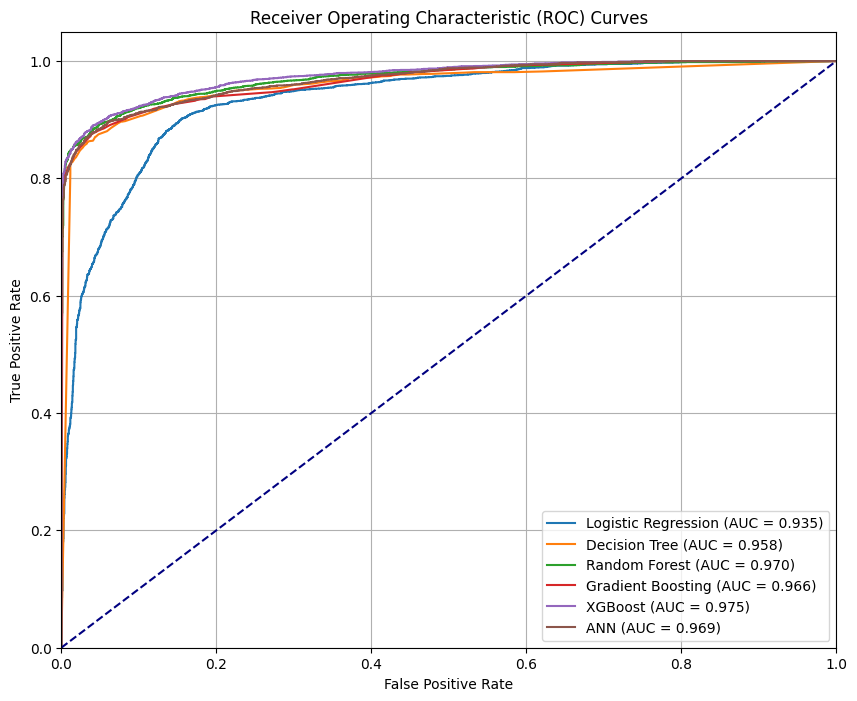

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, y_pred_prob in y_pred_probs:
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Model Evaluation for Multi Classification

In [ ]:
# Load the datasets

X_train_lr_m = pd.read_csv('data/Multi/train/lr_multi_train.csv')
X_train_dt_m = pd.read_csv('data/Multi/train/dt_multi_train.csv')
X_train_rf_m = pd.read_csv('data/Multi/train/rf_multi_train.csv')
X_train_gb_m = pd.read_csv('data/Multi/train/gb_multi_train.csv')
X_train_xg_m = pd.read_csv('data/Multi/train/xg_multi_train.csv')
X_train_ann_m = pd.read_csv('data/Multi/train/ann_multi_train.csv')

X_test_lr_m = pd.read_csv('data/Multi/test/lr_multi_test.csv')
X_test_dt_m = pd.read_csv('data/Multi/test/dt_multi_test.csv')
X_test_rf_m = pd.read_csv('data/Multi/test/rf_multi_test.csv')
X_test_gb_m = pd.read_csv('data/Multi/test/gb_multi_test.csv')
X_test_xg_m = pd.read_csv('data/Multi/test/xg_multi_test.csv')
X_test_ann_m = pd.read_csv('data/Multi/test/ann_multi_test.csv')

# Standardize the datasets using a separate scaler for each dataset
scaler_lr_m = StandardScaler()
scaler_dt_m = StandardScaler()
scaler_rf_m = StandardScaler()
scaler_gb_m = StandardScaler()
scaler_xg_m = StandardScaler()
scaler_ann_m = StandardScaler()

# Fit and transform the training data
X_train_lr_m_scaled = scaler_lr_m.fit_transform(X_train_lr_m)
X_train_dt_m_scaled = scaler_dt_m.fit_transform(X_train_dt_m)
X_train_rf_m_scaled = scaler_rf_m.fit_transform(X_train_rf_m)
X_train_gb_m_scaled = scaler_gb_m.fit_transform(X_train_gb_m)
X_train_xg_m_scaled = scaler_xg_m.fit_transform(X_train_xg_m)
X_train_ann_m_scaled = scaler_ann_m.fit_transform(X_train_ann_m)

# Transform the test data using the same scalers fitted on the training data
X_test_lr_m_scaled = scaler_lr_m.transform(X_test_lr_m)
X_test_dt_m_scaled = scaler_dt_m.transform(X_test_dt_m)
X_test_rf_m_scaled = scaler_rf_m.transform(X_test_rf_m)
X_test_gb_m_scaled = scaler_gb_m.transform(X_test_gb_m)
X_test_xg_m_scaled = scaler_xg_m.transform(X_test_xg_m)
X_test_ann_m_scaled = scaler_ann_m.transform(X_test_ann_m)

y_test_m = pd.read_csv('data/Multi/y_test_multi.csv')['at_risk_multi_encoded'].values

In [ ]:
# Load the models
model_files = [
    'Multi/best_lr_model_multi.pkl',
    'Multi/best_dt_model_multi.pkl',
    'Multi/best_rf_model_multi.pkl',
    'Multi/best_gb_model_multi.pkl',
    'Multi/best_xg_model_multi.pkl'
]

model_names_m = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
models_m = []

for file_path in model_files:
    try:
        model = joblib.load(file_path)
        models_m.append(model)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

In [ ]:
# Load the ANN model
ann_model_multi = tf.keras.models.load_model('Multi/best_ann_model_multi.keras')

c:\Users\jingt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate function for non-ANN models
def evaluate_model_multi(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Evaluate function for ANN model
def evaluate_ann_model_multi(model, X_test, y_test):
    y_pred = model.predict(X_test).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

In [ ]:
# Evaluate all models
datasets_m = [X_test_lr_m_scaled, X_test_dt_m_scaled, X_test_rf_m_scaled, X_test_gb_m_scaled, X_test_xg_m_scaled]
results_m = []
y_pred_probs_m = []  # Store predicted probabilities for ROC curve

for model, X_test, name in zip(models_m, datasets_m, model_names_m):
    y_pred_prob = model.predict_proba(X_test)  # Get predicted probabilities for ROC curve
    y_pred_probs_m.append((name, y_pred_prob))
    
    metrics = evaluate_model_multi(model, X_test, y_test_m)
    metrics['Model'] = name
    results_m.append(metrics)

# Evaluate ANN model
y_pred_prob_ann_m = ann_model_multi.predict(X_test_ann_m_scaled)  # Get predicted probabilities for ROC curve
y_pred_probs_m.append(('ANN', y_pred_prob_ann_m))

ann_metrics_m = evaluate_ann_model_multi(ann_model_multi, X_test_ann_m_scaled, y_test_m)
ann_metrics_m['Model'] = 'ANN'
results_m.append(ann_metrics_m)

# Create DataFrame and move the Model column to the front
results_df_m = pd.DataFrame(results_m)
results_df_m = results_df_m[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

# Display the results
print("Model Performance Metrics:")
results_df_m

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
Model Performance Metrics:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.730480,0.721143,0.730480,0.722838,0.856427
1,Decision Tree,0.800430,0.785183,0.800430,0.789323,0.908656
2,Random Forest,0.816843,0.801604,0.816843,0.803320,0.929504
3,Gradient Boosting,0.819297,0.804936,0.819297,0.807112,0.931755
4,XGBoost,0.821905,0.808065,0.821905,0.809997,0.933940
5,ANN,0.812548,0.797117,0.812548,0.799566,0.927240


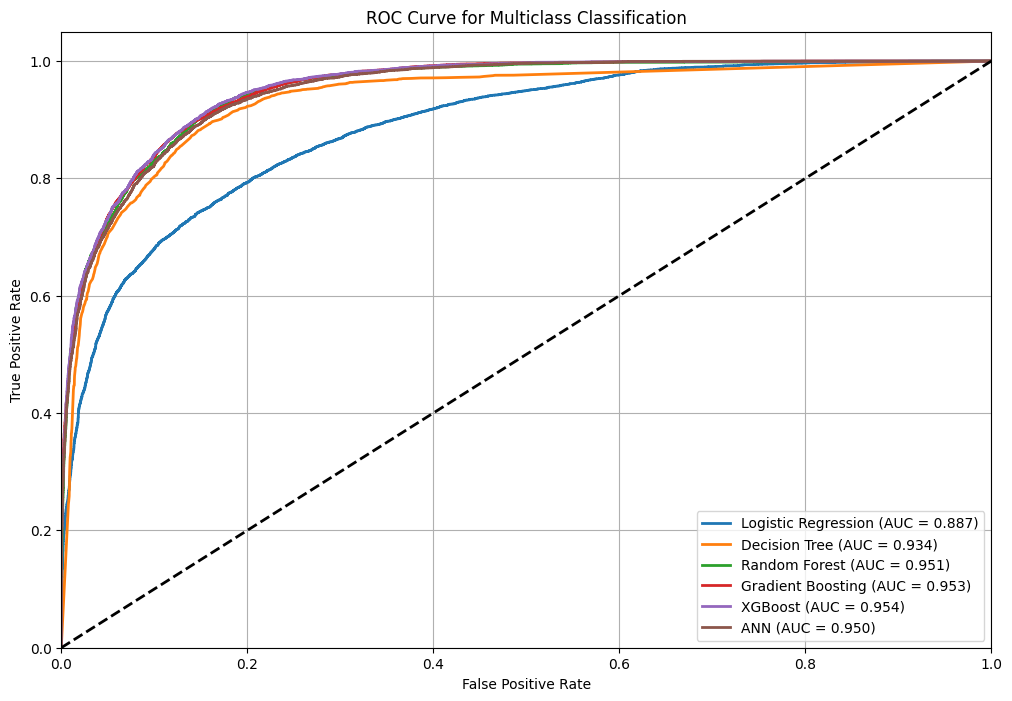

In [ ]:
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve for each model
def plot_multiclass_roc(y_test, y_pred_probs, model_names, n_classes):
    plt.figure(figsize=(12, 8))
    
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])
    
    for model_name, y_pred_prob in zip(model_names, y_pred_probs):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot micro-average ROC curve
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Define number of classes
n_classes = len(set(y_test_m))

# Prepare data for ROC curve plotting
y_pred_probs_m_ordered = [prob for _, prob in y_pred_probs_m]
model_names_m_ordered = [name for name, _ in y_pred_probs_m]

# Plot ROC curves
plot_multiclass_roc(y_test_m, y_pred_probs_m_ordered, model_names_m_ordered, n_classes)
